In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import pickle
import cloudpickle
from comparers import ModelComparer
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order,\
                       plot_feature_importance_bar, plot_class_importances,\
                       estimate_feature_interaction_order
from clustering import make_clustering
from tasks.adult import make_task_modified_hours_per_week as make_task
import matplotlib.pyplot as plt
from IPython.display import display
import shap
import warnings
shap.initjs()
warnings.filterwarnings(action='ignore', category=UserWarning)  # xgboost classifiers print lots of warnings

# Setup Task

In [2]:
categorical_features = ['Workclass', 'Education-Num', 'Marital Status', 'Occupation',
                        'Relationship', 'Race', 'Sex', 'Country']

In [3]:
clf_a, clf_b, X, X_display, y, feature_names = make_task()
comparer = ModelComparer(clf_a, clf_b, feature_names)

[17:58:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:58:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:58:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [6]:
# Here I use a sample of the recommended size to reduce the generation time
masker = shap.maskers.Independent(data=X, max_samples=100)

In [4]:
%%time
diffclf_shap_values = generate_shap_explanations(comparer, X, masker=masker, algorithm='exact', explanation_type='mclass_diff', space_type='log_odds')
with open('diffclf.shap', 'wb') as f:
    pickle.dump(diffclf_shap_values, f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 6514it [33:39,  3.22it/s]                            


CPU times: user 1h 30min 11s, sys: 4min 39s, total: 1h 34min 51s
Wall time: 33min 40s


# Difference Classifier SHAP Explanations

In [4]:
with open('diffclf.test.shap', 'rb') as f:
    diffclf_shap_values = pickle.load(f)

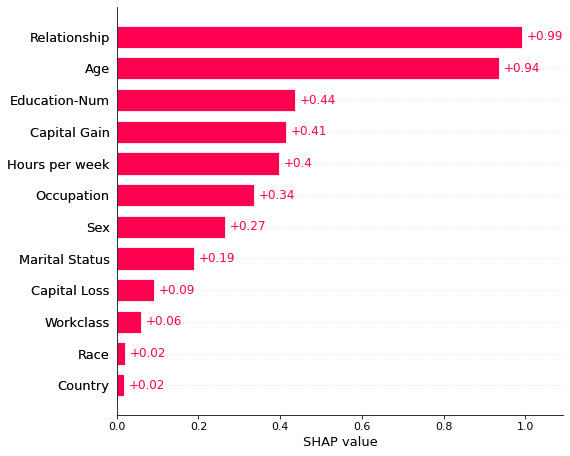

In [5]:
feature_order, feature_importances = calc_feature_order(diffclf_shap_values)
plot_feature_importance_bar(feature_importances)

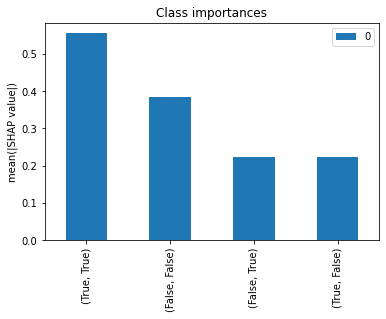

In [6]:
class_order, class_importances = calc_class_order(diffclf_shap_values)
plot_class_importances(class_importances, class_order, diffclf_shap_values.output_names)

## Clustering of Class $(False, True)$ SHAP Values

In [7]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(False, True)',
                       ['(False, False)', '(False, True)', '(True, True)'],
                       categorical_features=categorical_features)
node.class_counts, node.distance

CPU times: user 27.4 s, sys: 1.38 s, total: 28.7 s
Wall time: 9.93 s


((False, False)    5293
 (True, True)      1216
 (False, True)        3
 (True, False)        1
 dtype: int64,
 415.55082548875737)

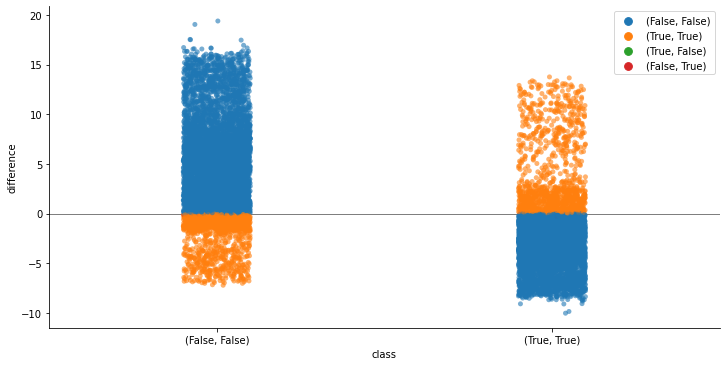

{'(False, False)': '-0.17 to -0.09', '(True, True)': '-0.25 to -0.05'}


In [8]:
node.plot_outcome_differences()

### Node RLRLRRRRRRR

In [9]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRLRRRRRRR,
 (False, False)    544
 (True, True)      192
 (False, True)       3
 dtype: int64,
 9.376066432483904)

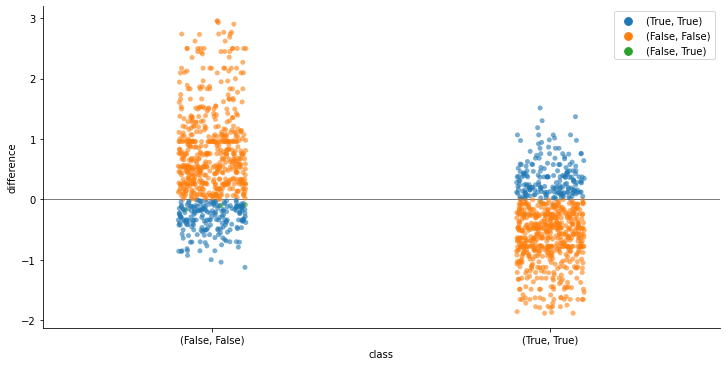

{'(False, False)': '-0.17 to -0.09', '(True, True)': '-0.25 to -0.05'}


In [10]:
node.plot_outcome_differences()

From global explanations, we can already interpret:
- Differences occur for Relationship == 4, but change only for 3
- Differences occur over a broad range of Age, but cease below 29 and above 62, where both classifiers predict False
- Differences occur for hours per week from 41 to 48, below both conclude on False and above on True
- Difference occur for Education-Num 10 and 11, with close counterfactuals. Below both conclude on False and above on True.
- Differences occur for Sex = 1, both conclude on False for Sex = 0. This is an interesting insight, because both classifiers picked up that Sex = 1 (male) is more likely to mean high income while Sex = 0 (female) is less likely to mean high income.
- Only instances with low Capital Gain are affected.

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 3}


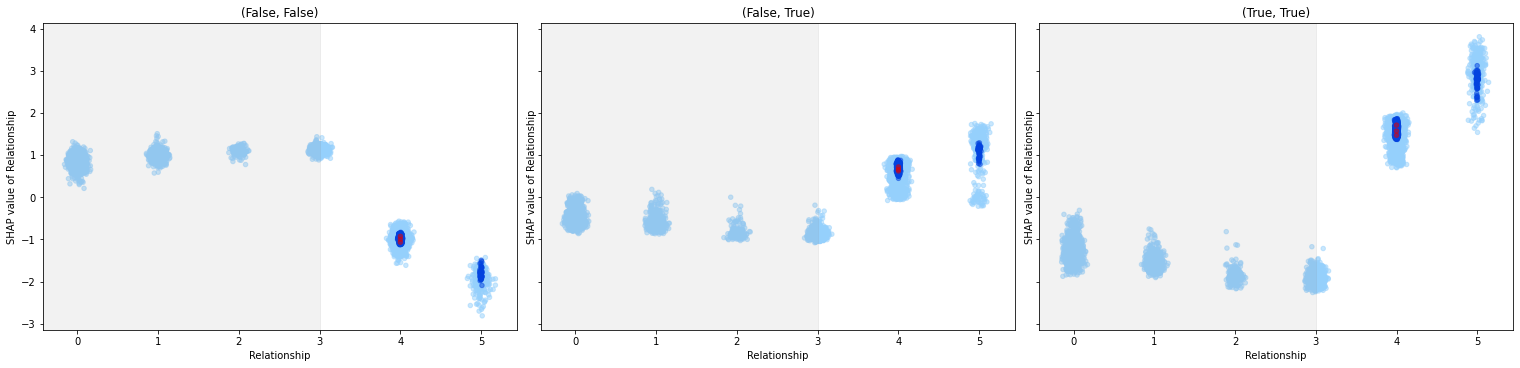

30.0 <= Age <= 56.0
Age <= 29.0 --> {'(False, False)': 3}
Age >= 62.0 --> {'(False, False)': 2, '(True, True)': 1}


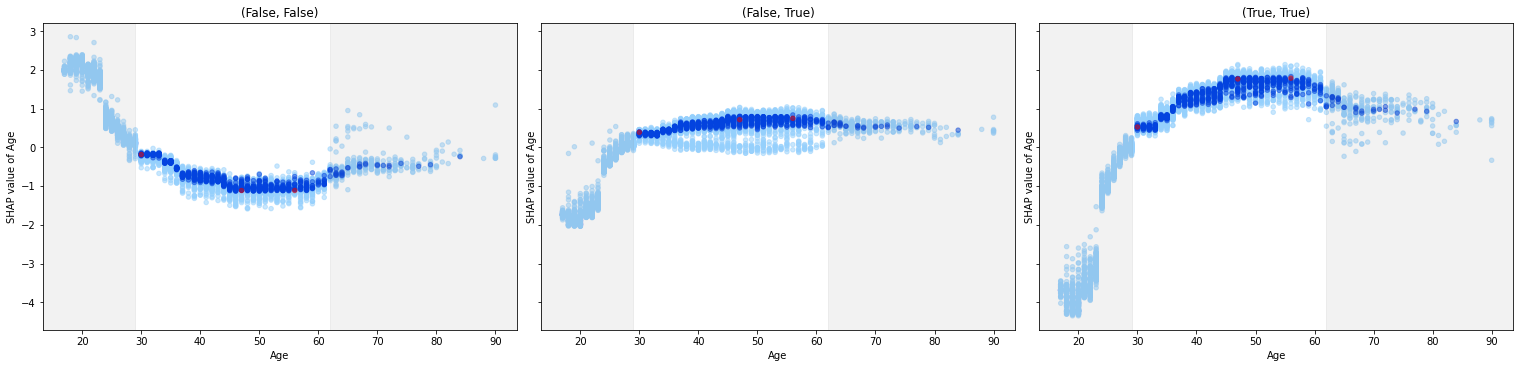

1.0 <= Occupation <= 4.0
Occupation <= 0.0 --> {'(False, False)': 3}
Occupation >= 5.0 --> {'(False, False)': 3}


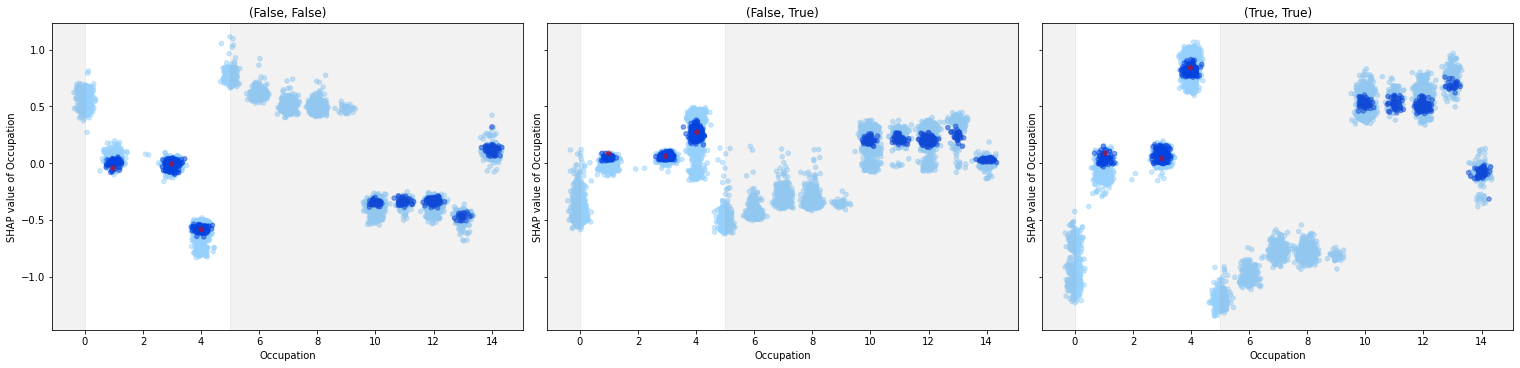

41.0 <= Hours per week <= 48.0
Hours per week <= 40.0 --> {'(False, False)': 3}
Hours per week >= 49.0 --> {'(True, True)': 3}


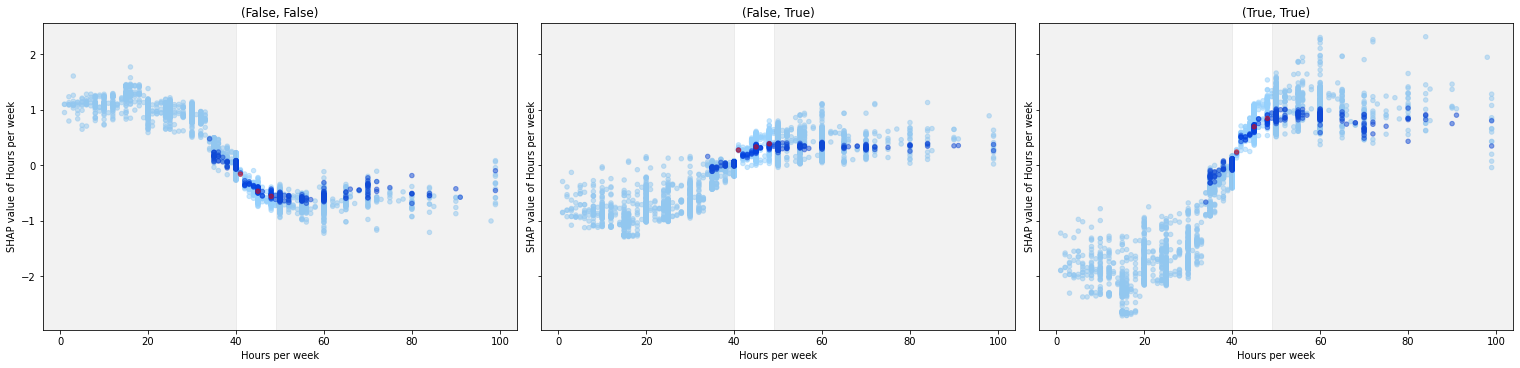

10.0 <= Education-Num <= 11.0
Education-Num <= 9.0 --> {'(False, False)': 3}
Education-Num >= 13.0 --> {'(True, True)': 3}


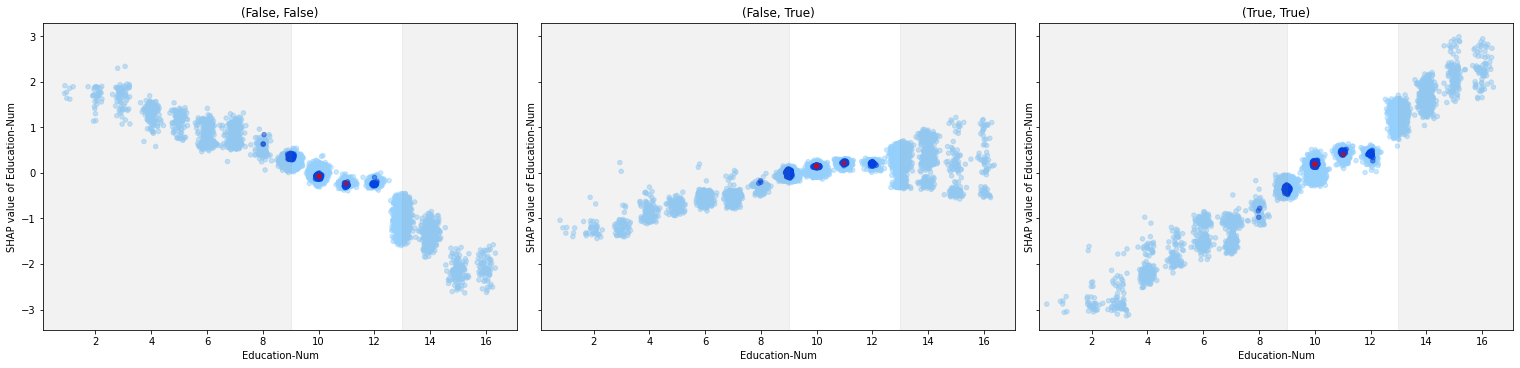

Sex == 1.0
Sex <= 0.0 --> {'(False, False)': 3}


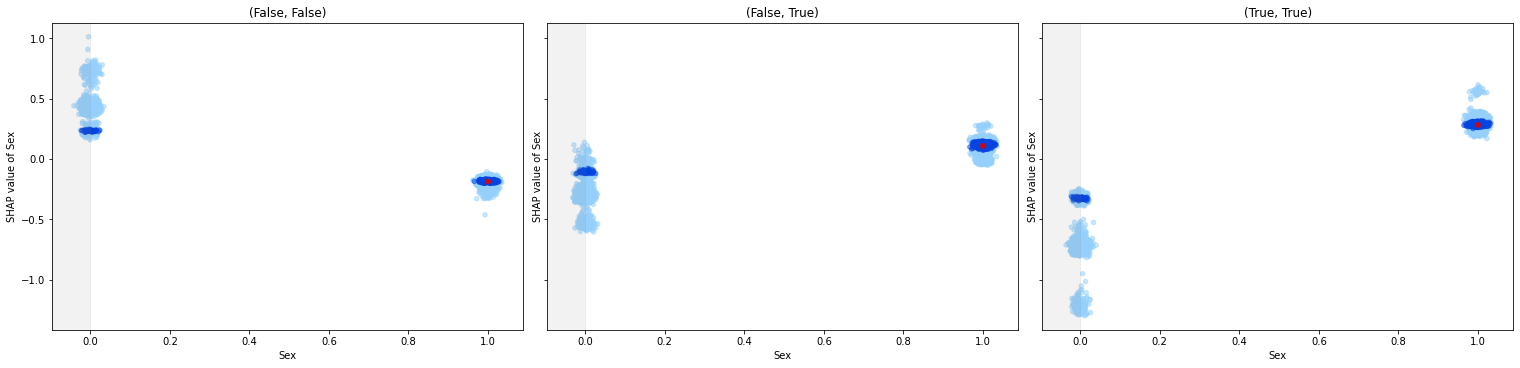

Marital Status == 2.0
Marital Status >= 4.0 --> {'(False, False)': 3}


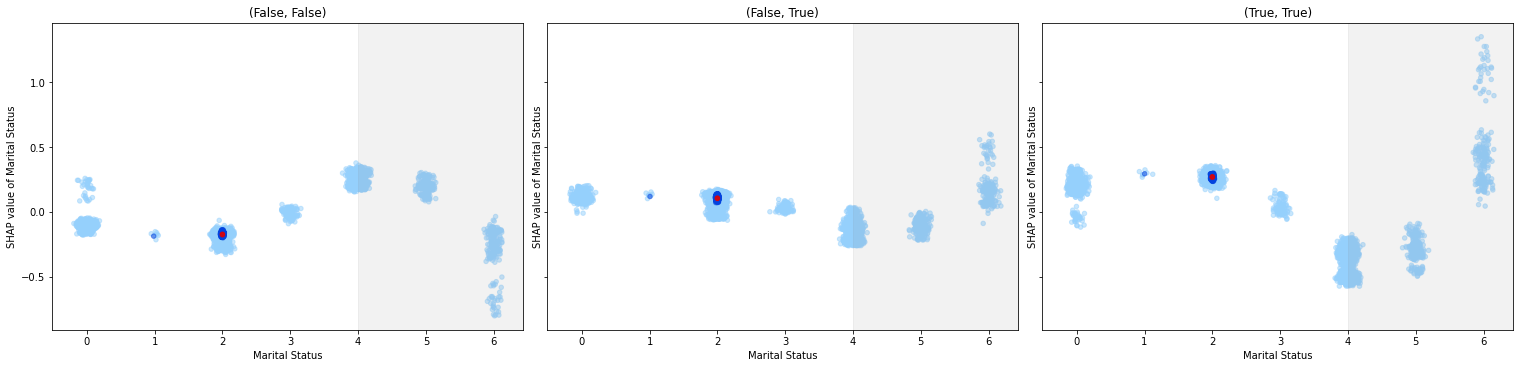

Capital Gain == 0.0
Capital Gain >= 57.0 --> {'(False, False)': 3}


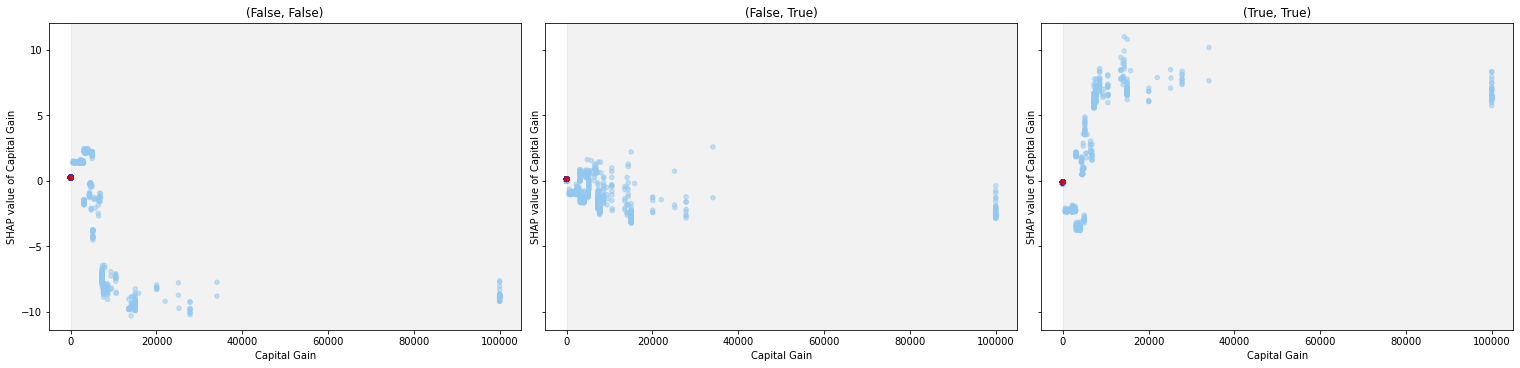

2.0 <= Workclass <= 4.0
Workclass <= 1.0 --> {'(True, True)': 3}
Workclass >= 6.0 --> {'(False, False)': 3}


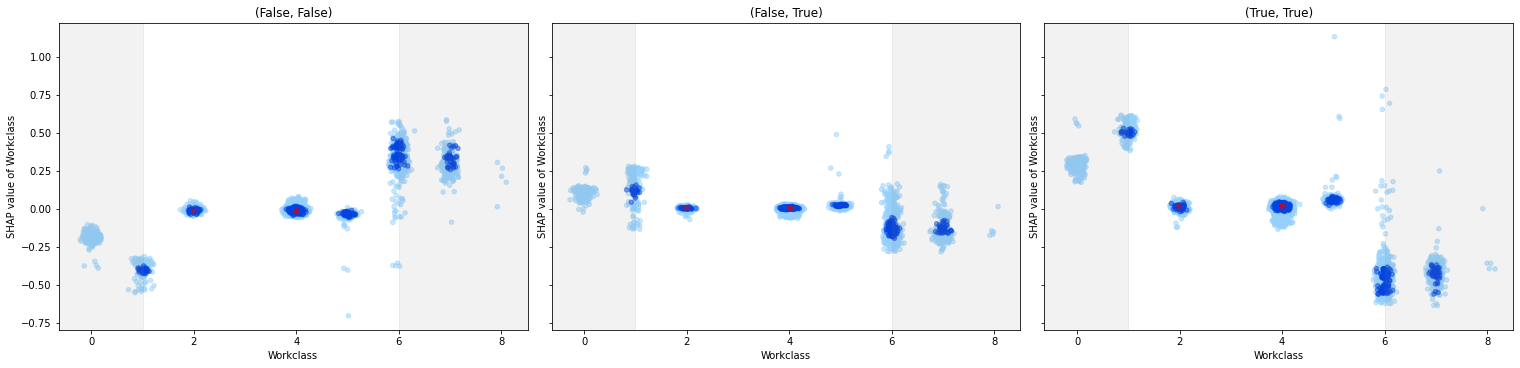

Capital Loss == 0.0
Capital Loss >= 732.0 --> {'(False, False)': 3}


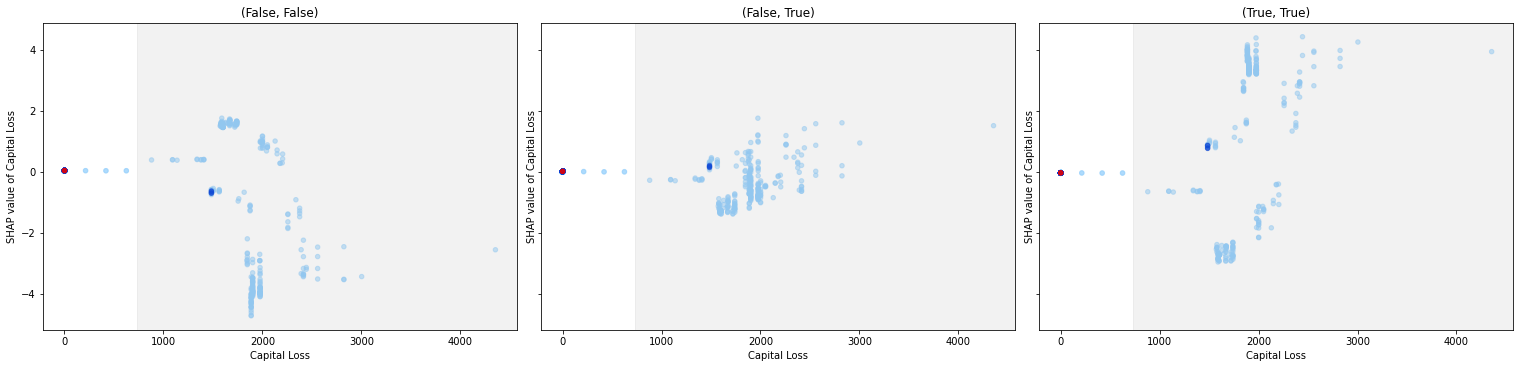

Race == 4.0
Race <= 3.0 --> {'(False, False)': 3}


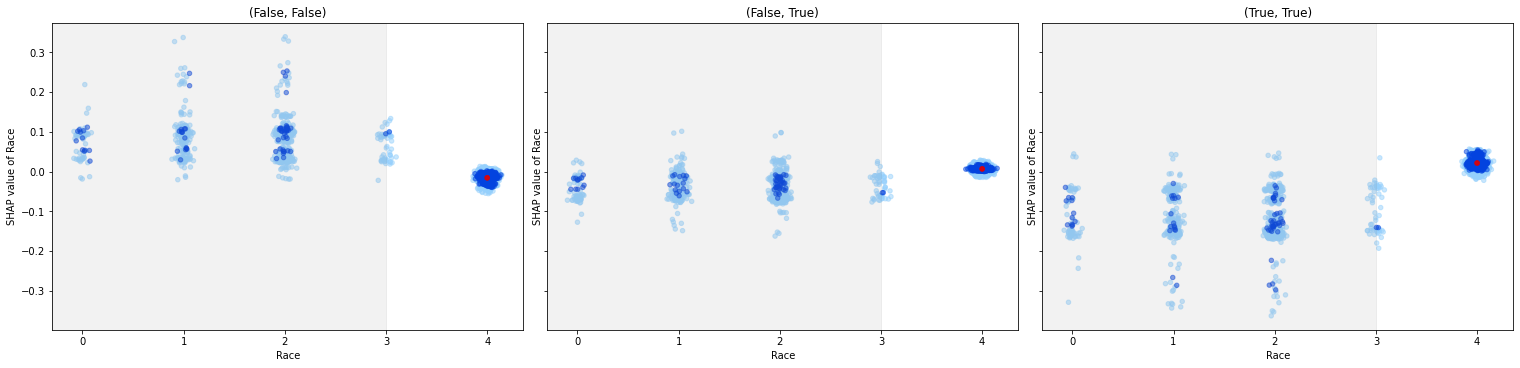

In [11]:
for feature in node.feature_names_relevant:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

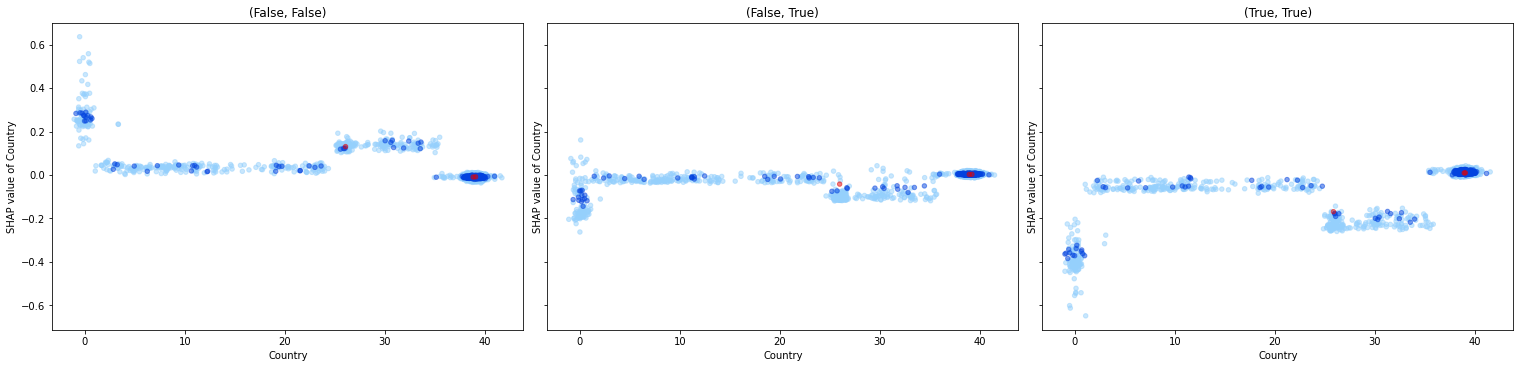

In [12]:
other_features = ~np.isin(comparer.feature_names, node.feature_names_relevant)
for feature in comparer.feature_names[other_features]:
    node.root.plot_feature_dependence(feature, focus=node, alpha=0.5)

### Node RLRLRRRRRRRL

In [13]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRLRRRRRRRL,
 (False, False)    167
 (True, True)      109
 (False, True)       2
 dtype: int64,
 5.1549021420056)

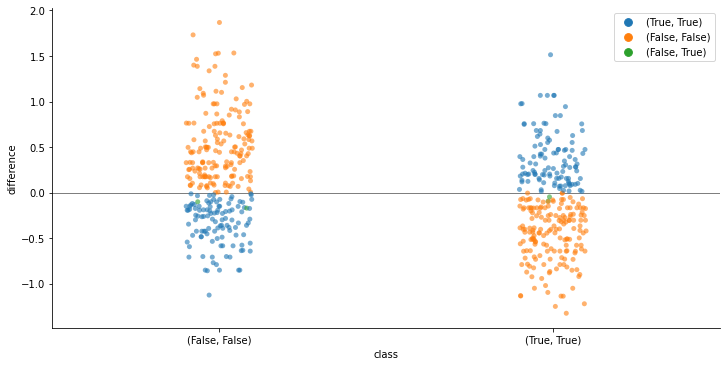

{'(False, False)': '-0.17 to -0.1', '(True, True)': '-0.09 to -0.05'}


In [14]:
node.plot_outcome_differences()

For these two instances, Relationship == 5 is now an upper counterfactual.

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 2}
Relationship >= 5.0 --> {'(True, True)': 2}


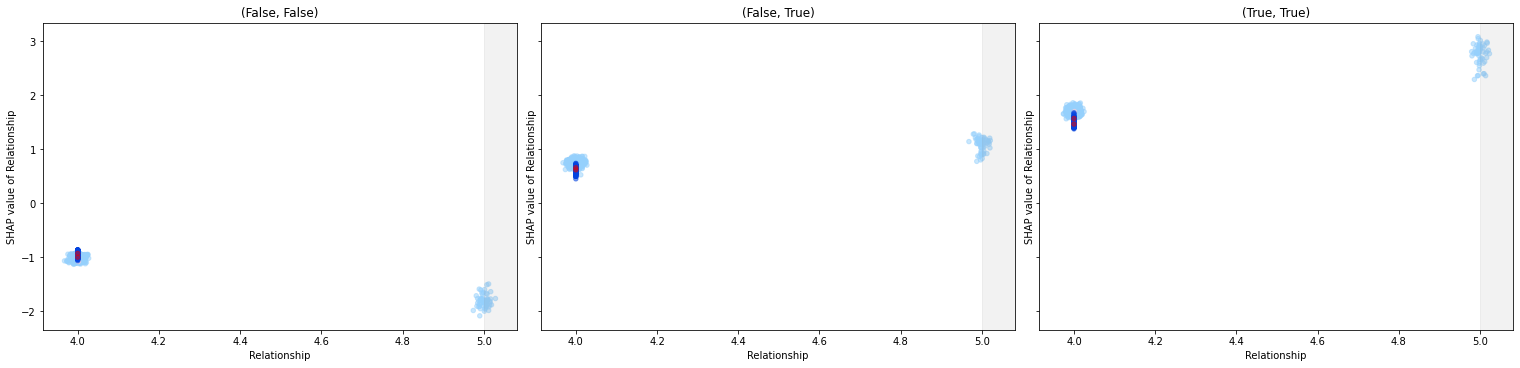

30.0 <= Age <= 47.0
Age <= 29.0 --> {'(False, False)': 2}
Age >= 62.0 --> {'(True, True)': 1, '(False, False)': 1}


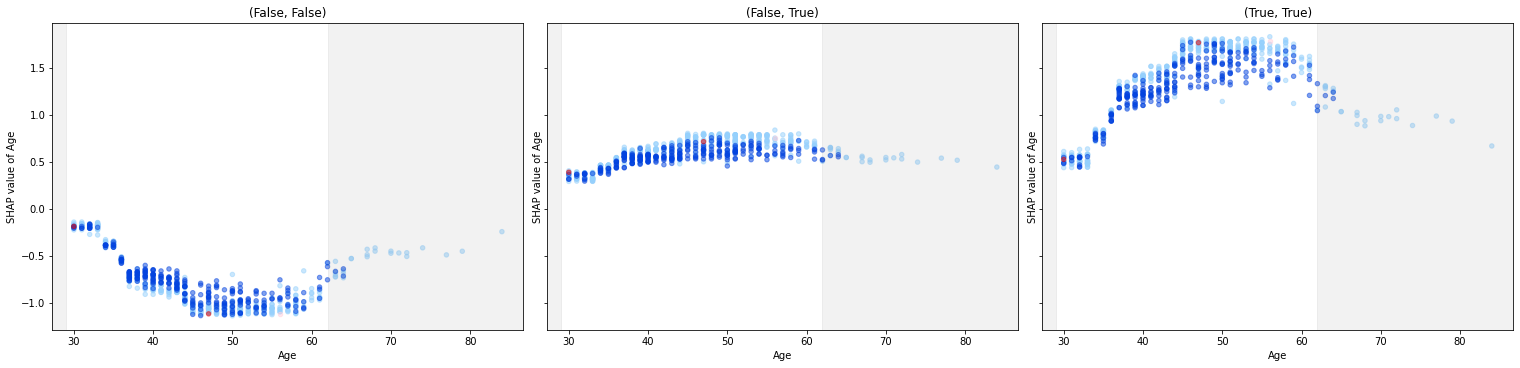

45.0 <= Hours per week <= 48.0
Hours per week <= 44.0 --> {'(False, False)': 2}
Hours per week >= 49.0 --> {'(True, True)': 2}


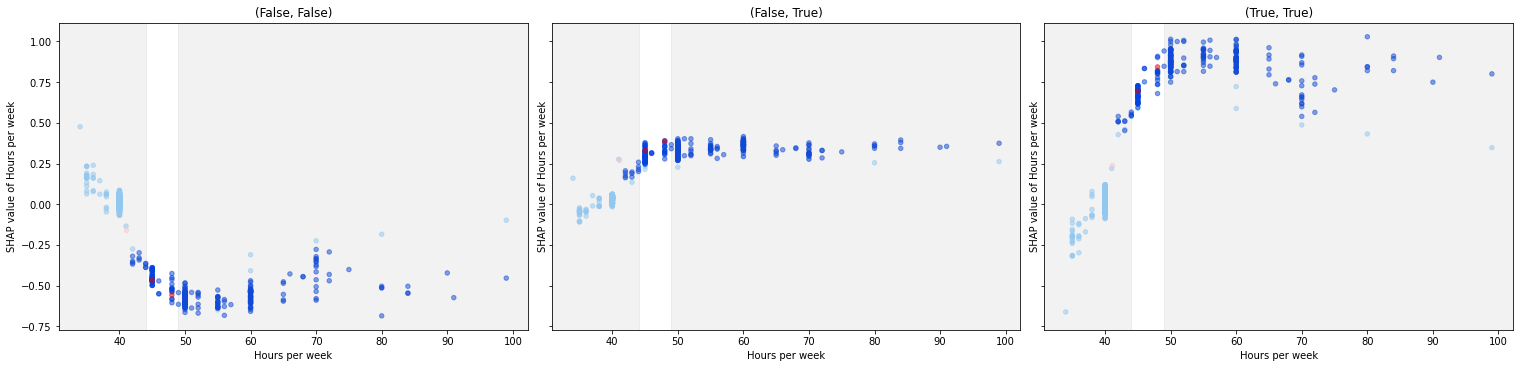

In [15]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.parent.plot_feature_dependence(feature, focus=node, alpha=0.5)

### Node RLRLRRRRRRRLLRRRLRLLL

In [16]:
node = node.get_left().get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRLRRRRRRRLLRRRLRLLL,
 (False, True)    1
 dtype: int64,
 0)

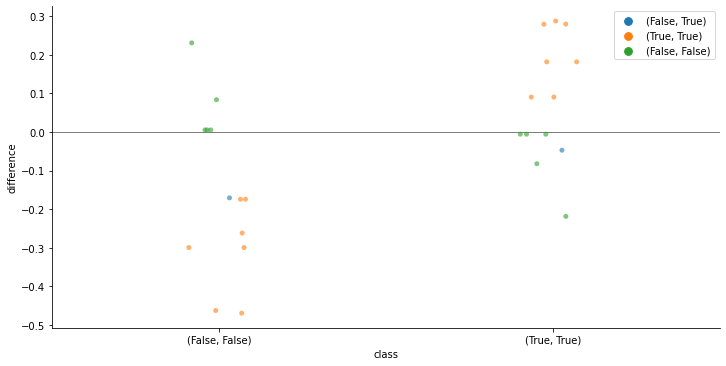

{'(False, False)': '-0.17 to -0.17', '(True, True)': '-0.05 to -0.05'}


In [17]:
node.get_parent(3).plot_outcome_differences()

The relationship explanation is not different for this instance from the parent explanation. Age has a higher low counterfactual. Hours per week is a very local difference.

Age == 47.0
Age <= 43.0 --> {'(False, False)': 1}
Age >= 62.0 --> {'(False, False)': 1}


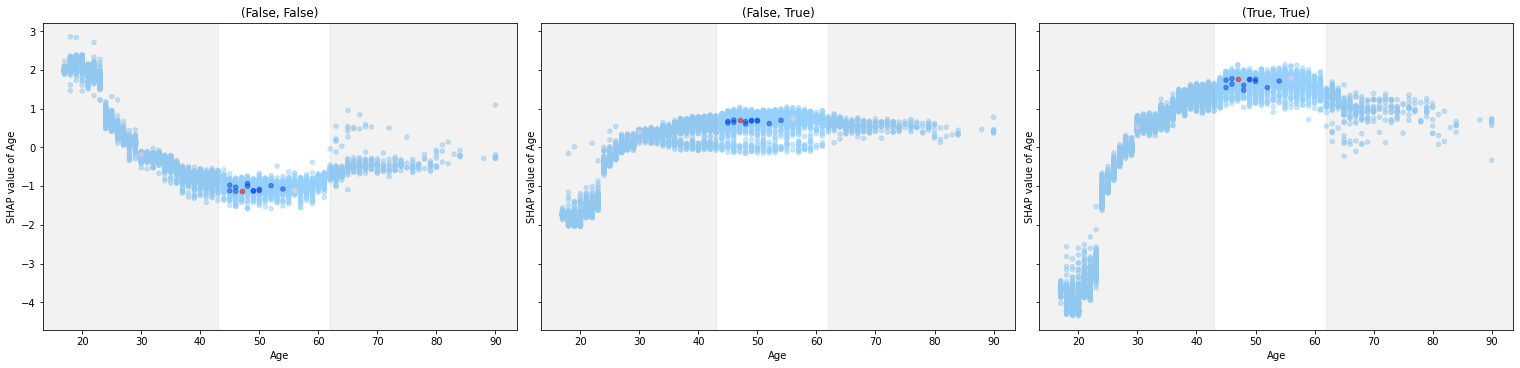

Relationship == 4.0
Relationship <= 3.0 --> {'(False, False)': 1}
Relationship >= 5.0 --> {'(True, True)': 1}


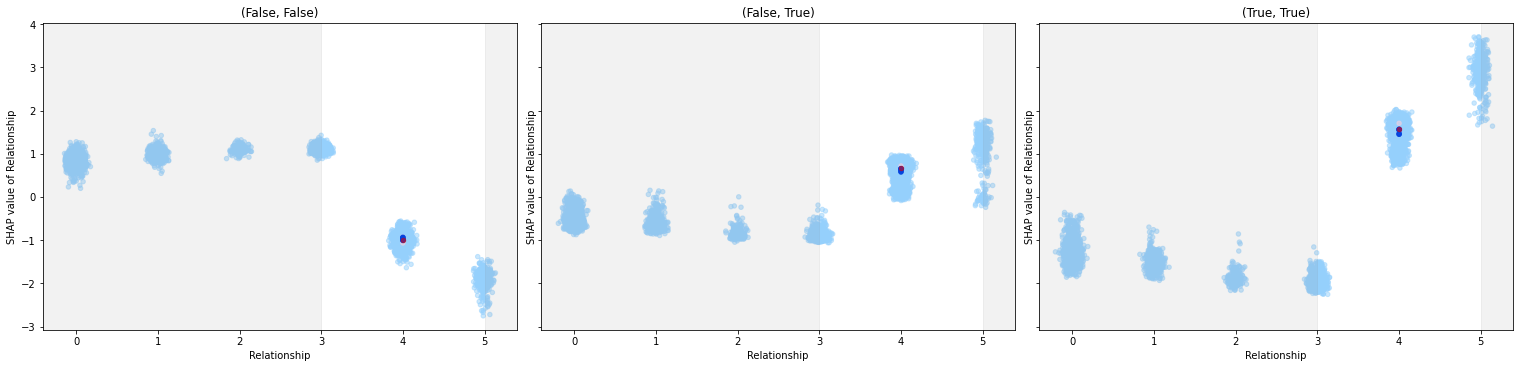

Hours per week == 45.0
Hours per week <= 44.0 --> {'(False, False)': 1}
Hours per week >= 46.0 --> {'(True, True)': 1}


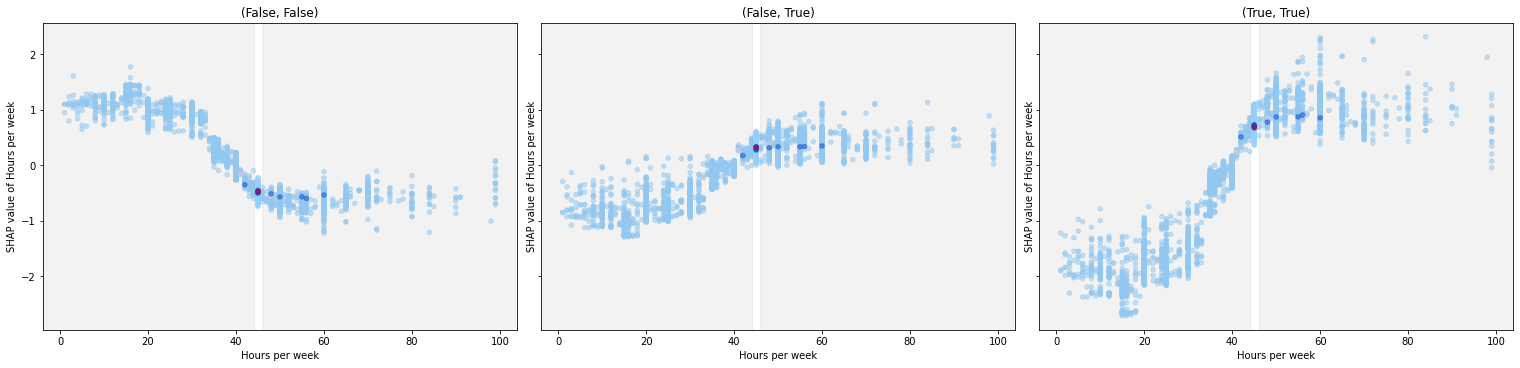

In [18]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.get_parent(3), alpha=0.5)

### Node RLRLRRRRRRRLR

In [19]:
node = node.root.get('RLRLRRRRRRRLR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

(RLRLRRRRRRRLRLRRRLLR,
 (False, True)    1
 dtype: int64,
 0)

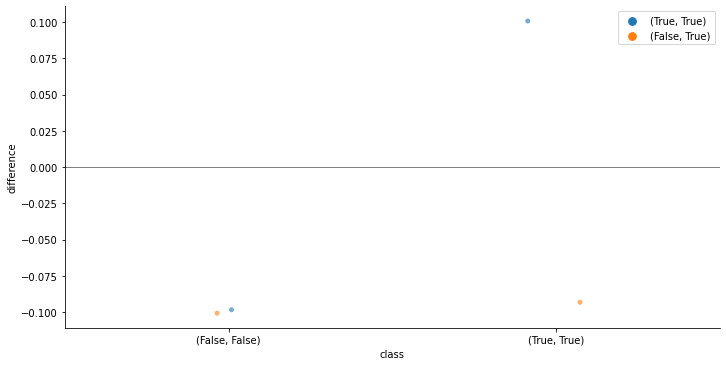

{'(False, False)': '-0.1 to -0.1', '(True, True)': '-0.09 to -0.09'}


In [20]:
node.parent.plot_outcome_differences()

This instance is in a lower age group, and thus has different counterfactuals. Hours per week is a very local difference here as well.

In [21]:
node.find_cf_up('Age')

AttributeError: 'ExplanationNode' object has no attribute 'find_cf_up'

In [ ]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.parent, alpha=0.5)

### Node RLRLRRRRRRRRRRRLLRRL

In [ ]:
node = node.root.get('RLRLRRRRRRRR').get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

In [ ]:
node.parent.plot_outcome_differences()

For this instance, Relationship has no upper counterfactual. The Age explanation is similar as for the first instance. Now occupation is ranked third most important locally, with counterfactuals at 0 and 4.

In [ ]:
for feature in node.feature_names_relevant[:3]:
    node.describe_feature_differences(feature)
    node.describe_counterfactuals(feature)
    node.root.plot_feature_dependence(feature, focus=node.parent, alpha=0.5)

Hours per week is the most reasonable explanation, why this instance is classified differently in contrast to the other instance in this node.

## Clustering of Class $(True, False)$ SHAP Values

In [ ]:
%%time
node = make_clustering(comparer, diffclf_shap_values, '(True, False)',
                       ['(False, False)', '(True, False)', '(True, True)'],
                       categorical_features=categorical_features)
node, node.class_counts, node.distance

In [ ]:
node.plot_outcome_differences()

### Node RLRLRRRRRRR

In [ ]:
node = node.get_last_child_before_diff_class_split()
node, node.class_counts, node.distance

In [ ]:
node.parent.class_counts

In [ ]:
node.get_parent(3).plot_outcome_differences()

In [ ]:
feature = node.feature_names_relevant[0]
node.describe_feature_differences(feature)
node.describe_counterfactuals(feature)
node.root.plot_feature_dependence(feature, focus=node.get_parent(3), alpha=0.5)

In [ ]:
feature = node.feature_names_relevant[1]
node.describe_feature_differences(feature)
node.describe_counterfactuals(feature)
node.root.plot_feature_dependence(feature, focus=node.get_parent(3), alpha=0.5)

Even though the instance classified $(False, False)$ has the same value as the upper counterfactual of Education-Num, it describes a different class $(True, True)$.

In [ ]:
feature = node.feature_names_relevant[2]
node.describe_feature_differences(feature)
node.describe_counterfactuals(feature)
node.root.plot_feature_dependence(feature, focus=node.get_parent(3), alpha=0.5)

In [ ]:
feature = node.feature_names_relevant[2]
node.describe_feature_differences(feature)
node.describe_counterfactuals(feature)
node.get_parent(3).plot_feature_dependence(feature, alpha=0.5)

This instance is at the local maximum of the Hours per week dependence curve for the difference class. Decreasing it makes both concord on True, increasing it makes both concord on False.